In [1]:
import geopandas as gpd
import numpy as np
from shapely import geometry
from shapely.affinity import rotate
from shapely.affinity import scale
from shapely.affinity import translate
from collections import OrderedDict
from IPython.core.display import HTML
import os
%matplotlib inline

In [2]:
## parameter settings
# geometry_file = r"D:\Projects\Pr\3723.10\Werkfolder\catchments_raw.shp"
# svg_file = 'catchments_icons.txt'
# key_column = 'catchment_'

geometry_file = r"D:\Projects\Pr\3723.10\Werkfolder\ecowas_countries_WGS84.shp"
                
svg_file = 'country_icons.txt'
key_column = 'name'

folder_svg = r'T:\@niels\svg'
svg_width = 18
svg_height = 18
strokeWidth = 2

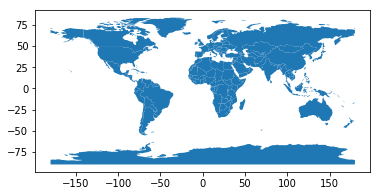

In [3]:
#gdf = gpd.read_file(geometry_file)
gdf = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
# only select geometries that are not none
gdf = gdf[~gdf['geometry'].isnull()]
gdf.plot()

In [4]:
gdf.tail()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982479287395 45.90887235802528,..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070000000004 42.58863000000008,..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59024654668023 41.85540891928363,..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000000000001 10.76, -61.105 10..."
176,13026129,Africa,S. Sudan,SSD,20880.0,"POLYGON ((30.83385242171543 3.509171604222463,..."


In [5]:
# sometimes are multiple row items for the same feature 
# disssolve features into multipolygon
gdf_dis = gdf.dissolve('name')

In [6]:
# from Polygon to LineString
for idx, row in gdf_dis.iterrows():
    geom = row['geometry']
    gdf_dis.at[idx, 'geometry'] = geom.boundary

In [7]:
gdf_dis.head()

,geometry,pop_est,continent,iso_a3,gdp_md_est
name,,,,,
Afghanistan,LINESTRING (66.51860680528867 37.3627843287587...,34124811,Asia,AFG,64080.0
Albania,LINESTRING (21.0200403174764 40.84272695572588...,3047987,Europe,ALB,33900.0
Algeria,LINESTRING (-8.684399786809053 27.395744126896...,40969443,Africa,DZA,609400.0
Angola,(LINESTRING (12.32243167486351 -6.100092461779...,29310273,Africa,AGO,189000.0
Antarctica,(LINESTRING (-163.7128956777287 -78.5956674132...,4050,Antarctica,ATA,810.0


In [8]:
def scale_locate_geom(geom, xmax, ymin, factor):
    x1, y1 = geom.xy
    round_vl = 3
    x1_round = (np.round(np.array(x1), round_vl) - xmax ) * factor
    y1_round = (np.round(np.array(y1), round_vl) - ymin ) * factor

    coords_round = list(zip(np.array(x1_round), np.array(y1_round)))
    unique_coords_round = OrderedDict.fromkeys(coords_round).keys() 

    geom = geometry.LinearRing(list(unique_coords_round)) 
    return geom

In [13]:
gdf_dis.continent[0]

'Asia'

In [37]:
for continent in gdf_dis.continent.unique():
    gdf_dis_cont = gdf_dis[gdf_dis.continent==continent]
    new_dict = {}
    for idx, row in gdf_dis_cont.iterrows():
        try:
            idx = row.name
            print(idx)

            # simplify geometry
            smp_geom = row['geometry'].simplify(0.1)
            xmin, ymin, xmax, ymax = row['geometry'].bounds

            # set factors for resizing
            factor_y = svg_height / (ymax-ymin)
            factor_x = svg_width / (xmax-xmin)

            if factor_y >= factor_x:
                factor = factor_x
            else:
                factor = factor_y

            # relocate and resize geometries
            if smp_geom.type == 'LineString':
                smp_gm = scale_locate_geom(smp_geom, xmax, ymin, factor)        

            if smp_geom.type == 'MultiLineString':
                new_geom = []
                for line in smp_geom:
                    ring = scale_locate_geom(line, xmax, ymin, factor)      
                    new_geom.append(ring)

                smp_gm = geometry.MultiLineString(new_geom)

            # rotate and flip
            smp_gm = rotate(smp_gm, 180)
            smp_gm = scale(smp_gm, xfact = -1, origin = (1, 0))

            # place geom in middle of dom
            xmin, ymin, xmax, ymax = smp_gm.bounds
            xoff = ((svg_width + strokeWidth * 2) / 2) - (np.round(xmax-xmin) / 2) + 1
            yoff = ((svg_height + strokeWidth * 2) / 2) - (np.round(ymax-ymin) / 2) + 1
            print(xoff, yoff)
            smp_mv_gm = translate(smp_gm, xoff, yoff)    

            # convert to svg and change styling
            item_svg = smp_mv_gm.svg()
            item_svg = item_svg.replace('stroke="#66cc99" stroke-width="2.0"', 'stroke="#BDBDBD" stroke-width="2.0"')
            item_svg = item_svg.replace(' opacity="0.8" ', '')    
            item_svg = item_svg.replace('<g>', "")
            item_svg = item_svg.replace('</g>', "")      

        #     onmouseover="evt.target.setAttribute('fill', '#2196F3');" onmouseout="evt.target.setAttribute('fill', 'none');"')""")
        #     item_svg = item_svg.replace('<polyline fill="none" stroke="#66cc99" stroke-width="2.0" ', '<polyline ') 
        #     item_svg = item_svg.replace('<polyline fill="none" stroke="#66cc99" stroke-width="2.0" ', '"polyline",{ ')
        #     item_svg = item_svg.replace(' opacity="0.8" ', '')
        #     item_svg = item_svg.replace('/>', '}')
        #     item_svg = item_svg.replace('points=', 'points: points=')
        #     item_svg = item_svg.replace('"}"polyline"', '}, "polyline"')
        #     item_svg = item_svg.replace('<g>', "[")
        #     item_svg = item_svg.replace('</g>', "]")    
            new_dict.update({idx: item_svg})
#             display(HTML(''' 
#                 <svg> 
#                 {}
#                 </svg >'''.format(item_svg)))    
        except:
            continue

        keys = new_dict.keys()
        with open(os.path.join(folder_svg, 'icons_continent_{}.txt'.format(continent)), 'w') as f:
            for key in keys:
                f.write('{}: \n{}\n\n'.format(key, new_dict[key]))
                
        df_cont = pd.DataFrame().from_dict(new_dict, orient='index').reset_index()
        df_cont.columns = ['country', 'svg_string']
        df_cont.to_csv(os.path.join(folder_svg, 'icons_continent_{}.csv'.format(continent)) ,index=False)                

Afghanistan
3.0 6.5
Armenia
3.0 4.5
Azerbaijan
3.0 6.0
Bangladesh
5.0 3.0
Bhutan
3.0 7.5
Brunei
4.0 3.0
Cambodia
3.0 5.0
China
3.0 7.0
Cyprus
3.0 9.0
Georgia
3.0 8.5
India
3.0 3.5
Indonesia
3.0 9.0
Iran
3.0 5.0
Iraq
3.0 4.5
Israel
8.5 3.0
Japan
3.0 4.0
Jordan
3.0 3.0
Kazakhstan
3.0 9.0
Kuwait
3.0 4.5
Kyrgyzstan
3.0 8.5
Laos
4.0 3.0
Lebanon
3.5 3.0
Malaysia
3.0 9.0
Mongolia
3.0 9.0
Myanmar
7.5 3.0
N. Cyprus
3.0 9.0
Nepal
3.0 7.5
North Korea
Oman
5.0 3.0
Pakistan
3.0 5.0
Palestine
7.5 3.0
Philippines
5.5 3.0
Qatar
7.0 3.0
Saudi Arabia
3.0 5.0
South Korea
5.0 3.0
Sri Lanka
7.0 3.0
Syria
3.0 5.5
Taiwan
7.0 3.0
Tajikistan
3.0 7.0
Thailand
7.0 3.0
Timor-Leste
3.0 7.5
Turkey
3.0 9.0
Turkmenistan
3.0 7.0
United Arab Emirates
3.0 5.5
Uzbekistan
3.0 7.5
Vietnam
7.5 3.0
Yemen
3.0 6.5
Albania
7.0 3.0
Austria
3.0 9.0
Belarus
3.0 7.5
Belgium
3.0 7.0
Bosnia and Herz.
3.0 6.0
Bulgaria
3.0 7.5
Croatia
3.0 5.5
Czechia
3.0 8.5
Denmark
3.0 6.5
Estonia
3.0 8.0
Finland
3.0 3.5
France
3.0 5.0
Germany
3.0 4.5

,country,svg_string
0,Fr. S. Antarctic Lands,"<polyline fill=""none"" stroke=""#BDBDBD"" stroke-..."


In [18]:
import pandas as pd

range(0, 1)